# Training your own StarDist model

This notebook was found on the StarDist GitHub repo and has been modified to train a model called (StarDist_Haug2) on manually annotated images of human cortical organoids to improve nuclei segmentation in dense region. 

In case of problems or questions, please first check the list of [Frequently Asked Questions (FAQ)](https://stardist.net/docs/faq.html).

Please shutdown all other training/prediction notebooks before running this notebook (as those might occupy the GPU memory otherwise).

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import os
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread, imsave
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

np.random.seed(42)
lbl_cmap = random_label_cmap()

2025-10-26 16:05:49.732609: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Image multiplication

This code has been used to multiply the number of annotated images and their corresponding masks to increase th enumber of images> First all images were rotated 90, 180 and 270 degress and then flipped to multiply the 447 images from the dsb18 and the 134 manually annotated images. All of them can be found in the data folder.

In [ ]:
# Define the paths
image_folder = '../data/stardist_haug2_training/train/images'
mask_folder = '../data/stardist_haug2_training/train/masks'
output_image_folder = os.path.join(image_folder, "augmented")
output_mask_folder = os.path.join(mask_folder, "augmented")


files = os.listdir(image_folder)  # Liste tous les fichiers/dossiers
total_files = len(files)  # Compte le nombre total


# Create output directories if they don't exist
os.makedirs(output_image_folder, exist_ok=True)
os.makedirs(output_mask_folder, exist_ok=True)

# Define the flip and rotation functions
def flip_image(img, flip_type):
    """ Flip image by 90, 180, or 270 degrees. """
    if flip_type == 'lr':  # left-right
        return np.fliplr(img)
    elif flip_type == 'ud':  # up-down
        return np.flipud(img)
    elif flip_type == 'lr_ud':  # left-right + up-down
        return np.flipud(np.fliplr(img))
    return img

def rotate_image(img, angle):
    """ Rotate image by 90, 180, or 270 degrees. """
    if angle == 90:
        return np.rot90(img)
    elif angle == 180:
        return np.rot90(img, 2)
    elif angle == 270:
        return np.rot90(img, 3)
    return img

with tqdm(total=total_files, ncols=80) as pbar:
    # Loop through all images in the image folder
    for filename in os.listdir(image_folder):
        if filename.endswith(".tif"):
            # Read image and corresponding mask
            image_path = os.path.join(image_folder, filename)
            mask_path = os.path.join(mask_folder, filename) 
            # Ensure the corresponding mask exists
            if not os.path.exists(mask_path):
                print(f"Mask for {filename} not found in {mask_folder}. Skipping this image.")
                continue

            # Load the image and mask
            img = imread(image_path)
            mask = imread(mask_path)

            # Apply each flip and rotation type, then save results
            for flip_type in ['original', 'lr', 'ud', 'lr_ud']:
                flipped_img = flip_image(img, flip_type) if flip_type != 'original' else img
                flipped_mask = flip_image(mask, flip_type) if flip_type != 'original' else mask

                for angle in [0, 90, 180, 270]:
                    # Rotate image and mask
                    rotated_img = rotate_image(flipped_img, angle) if angle != 0 else flipped_img
                    rotated_mask = rotate_image(flipped_mask, angle) if angle != 0 else flipped_mask

                    # Create a filename that includes both the flip type and rotation angle
                    base_name = os.path.splitext(filename)[0]
                    suffix = f"{flip_type}_{angle}deg" if angle != 0 else flip_type
                    img_save_path = os.path.join(output_image_folder, f"{base_name}_{suffix}.tif")
                    mask_save_path = os.path.join(output_mask_folder, f"{base_name}_{suffix}.tif")

                    # Save the augmented image and mask
                    imsave(img_save_path, rotated_img)
                    imsave(mask_save_path, rotated_mask)

                    pbar.update(1)

print("Flipping and rotation complete. All augmented images and masks are saved.")


112it [00:03, 35.55it/s]                                                        

Flipping and rotation complete. All augmented images and masks are saved.


# Data

<div class="alert alert-block alert-info">
Training data (for input `X` with associated label masks `Y`) can be provided via lists of numpy arrays, where each image can have a different size. Alternatively, a single numpy array can also be used if all images have the same size.  
Input images can either be two-dimensional (single-channel) or three-dimensional (multi-channel) arrays, where the channel axis comes last. Label images need to be integer-valued.
</div>

In [5]:
# Modify the path according to where your images and their corresponding masks are
X = sorted(glob('../data/stardist_haug2_training/train/images/*.tif'))
Y = sorted(glob('../data/stardist_haug2_training/train/masks/*.tif'))
print(f"found {len(X)} training images and {len(Y)} training masks")
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

found 581 training images and 581 training masks


In [5]:
X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

Normalize images and fill small label holes.

In [6]:
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████| 9296/9296 [01:44<00:00, 89.30it/s] 


Split into train and validation datasets.

In [7]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images: 9296
- training:       7902
- validation:     1394


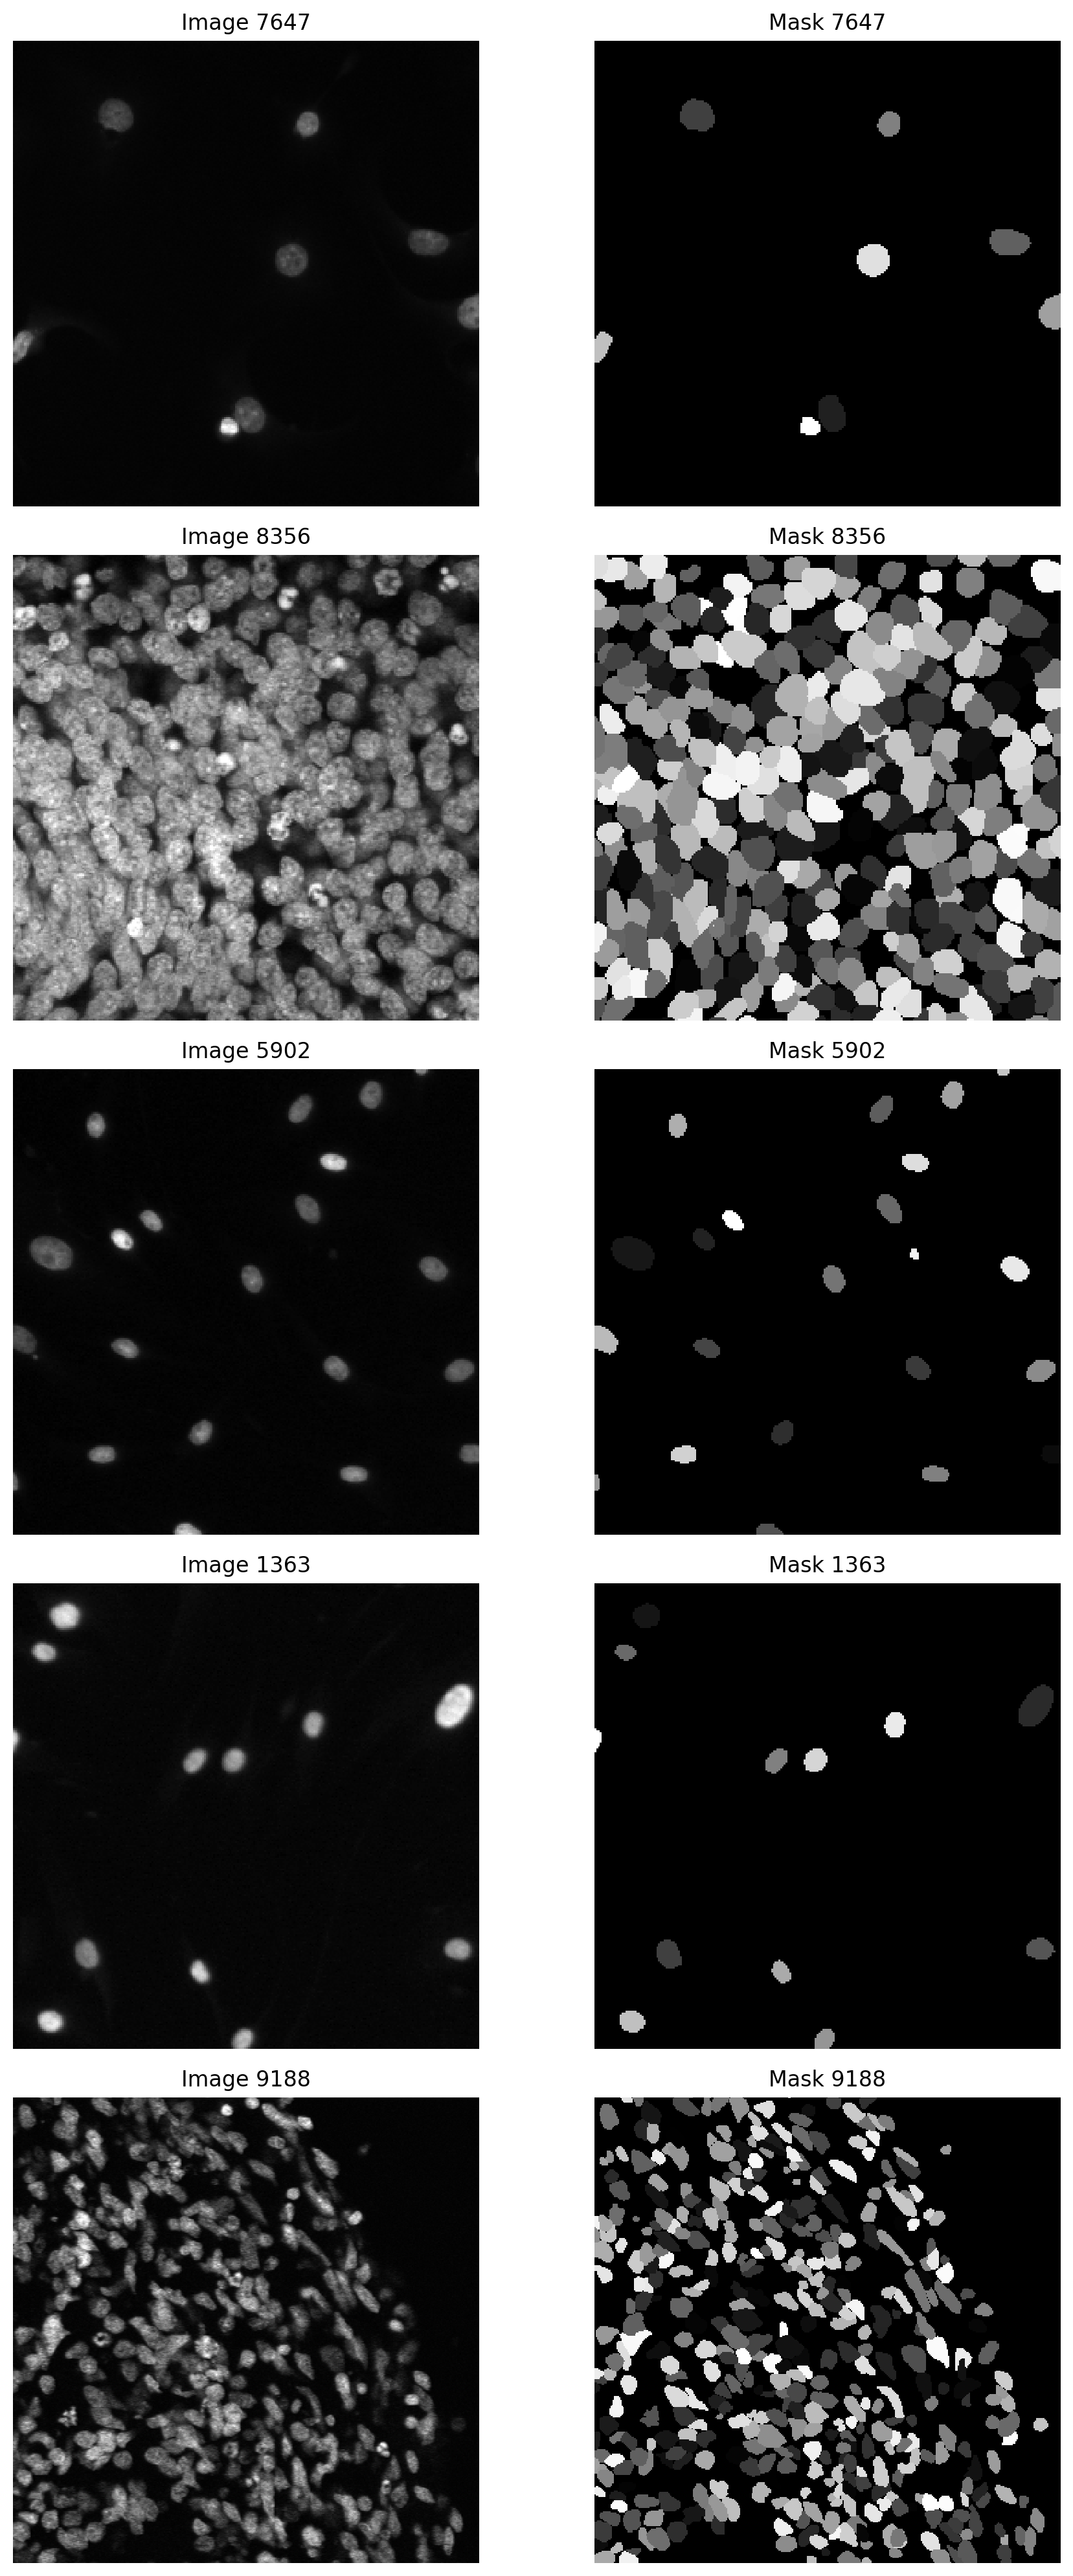

In [11]:
# Randomly select 20 indices from the list of images
random_indices = np.random.choice(len(X), 5, replace=False)

# Plot the images and masks
fig, ax = plt.subplots(5, 2, figsize=(10, 20))

for i, idx in enumerate(random_indices):
    ax[i, 0].imshow(X[idx], cmap='gray')
    ax[i, 0].axis('off')
    ax[i, 0].set_title(f"Image {idx}")
    
    ax[i, 1].imshow(Y[idx], cmap='gray')
    ax[i, 1].axis('off')
    ax[i, 1].set_title(f"Mask {idx}")

plt.tight_layout()
plt.show()

# Configuration

A `StarDist2D` model is specified via a `Config2D` object.

In [10]:
print(Config2D.__doc__)

Configuration for a :class:`StarDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    n_classes : None or int
        Number of object classes to use for multi-class predection (use None to disable)
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
   

In [11]:
# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
    train_batch_size = 8,
    train_epochs=500,
    train_steps_per_epoch=350,
    # patch sizes have been lowered
    train_patch_size= (96,96)
)

print(conf)
vars(conf)

If you want to compute separable approximations, please install it with
pip install scikit-tensor-py3
Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=1, n_channel_out=33, n_classes=None, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_background_reg=0.0001, train_batch_size=8, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_class_weights=(1, 1), train_completion_crop=32, train_dist_loss='mae', train_epochs=500, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_patch_size=(96, 96), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_sample_cache=True, train_shape_completion=False, train_steps_per_epoch=350, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=(3, 3), unet_last_activation='relu'

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': None,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (96, 96),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_weights': (1, 1),
 'train_epochs': 500,
 'train_steps_per_epoch': 350,
 'train_learning_rate': 0.0003,
 '

In [12]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    total_memory_in_MB = 8192  # replace this with your GPU's memory in MB
    limit_gpu_memory(0.8, total_memory=total_memory_in_MB)
    # alternatively, try this:
    # limit_gpu_memory(None, allow_growth=True, total_memory=total_memory_in_MB)


**Note:** The trained `StarDist2D` model will *not* predict completed shapes for partially visible objects at the image boundary if `train_shape_completion=False` (which is the default option).

In [ ]:
model = StarDist2D(conf, name='stardist_haug2', basedir='models')

Using default values: prob_thresh=0.5, nms_thresh=0.4.


Check if the neural network has a large enough field of view to see up to the boundary of most objects.

In [40]:
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

median object size:      [16. 16.]
network field of view :  [92 94]


# Data Augmentation

You can define a function/callable that applies augmentation to each batch of the data generator.  
We here use an `augmenter` that applies random rotations, flips, and intensity changes, which are typically sensible for (2D) microscopy images (but you can disable augmentation by setting `augmenter = None`).

In [ ]:
# Augmentations have been lowered to prevent oversaturation of pixels
def random_intensity_change(img):
    img = img*np.random.uniform(0.9, 1.1) + np.random.uniform(-0.05, 0.05)
    return img

def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x = random_intensity_change(x)
    # add some mild gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y


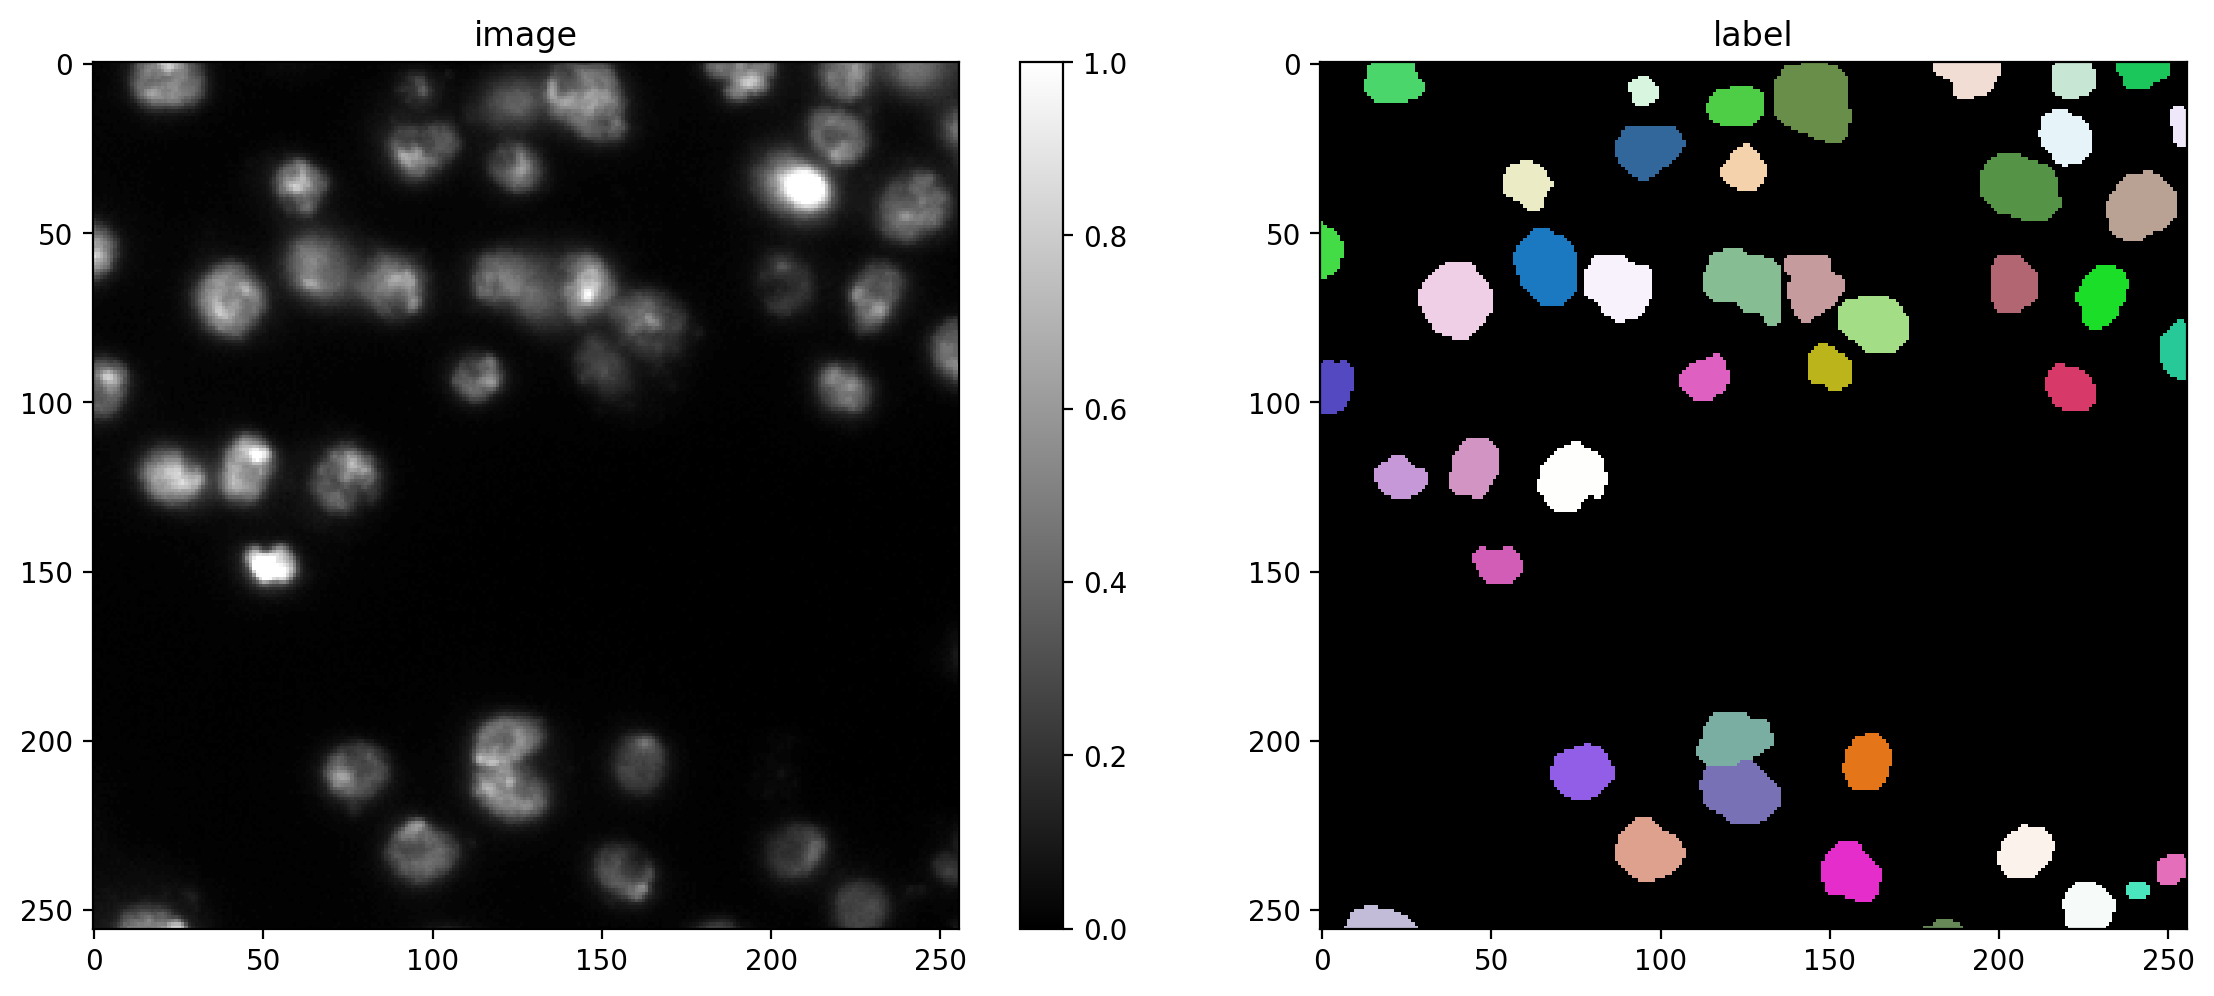

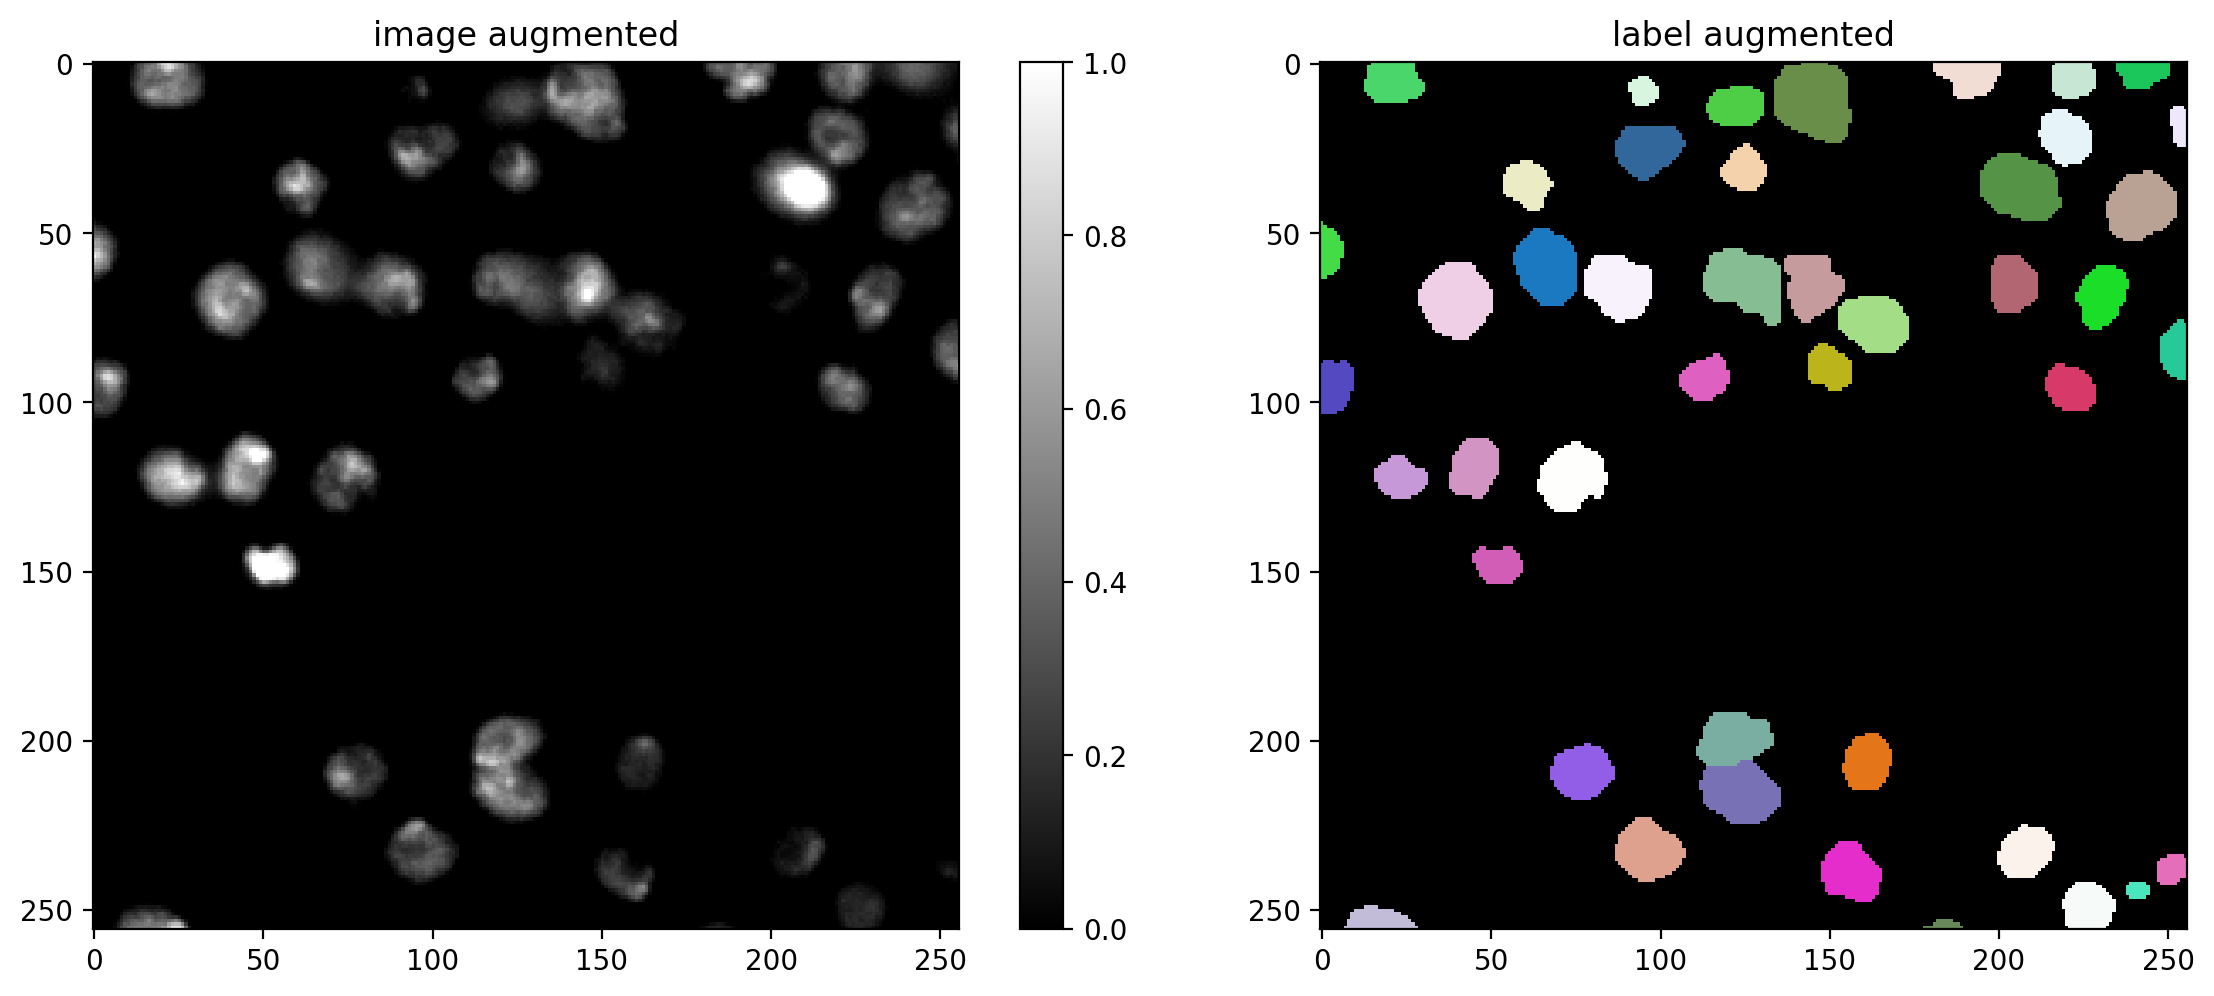

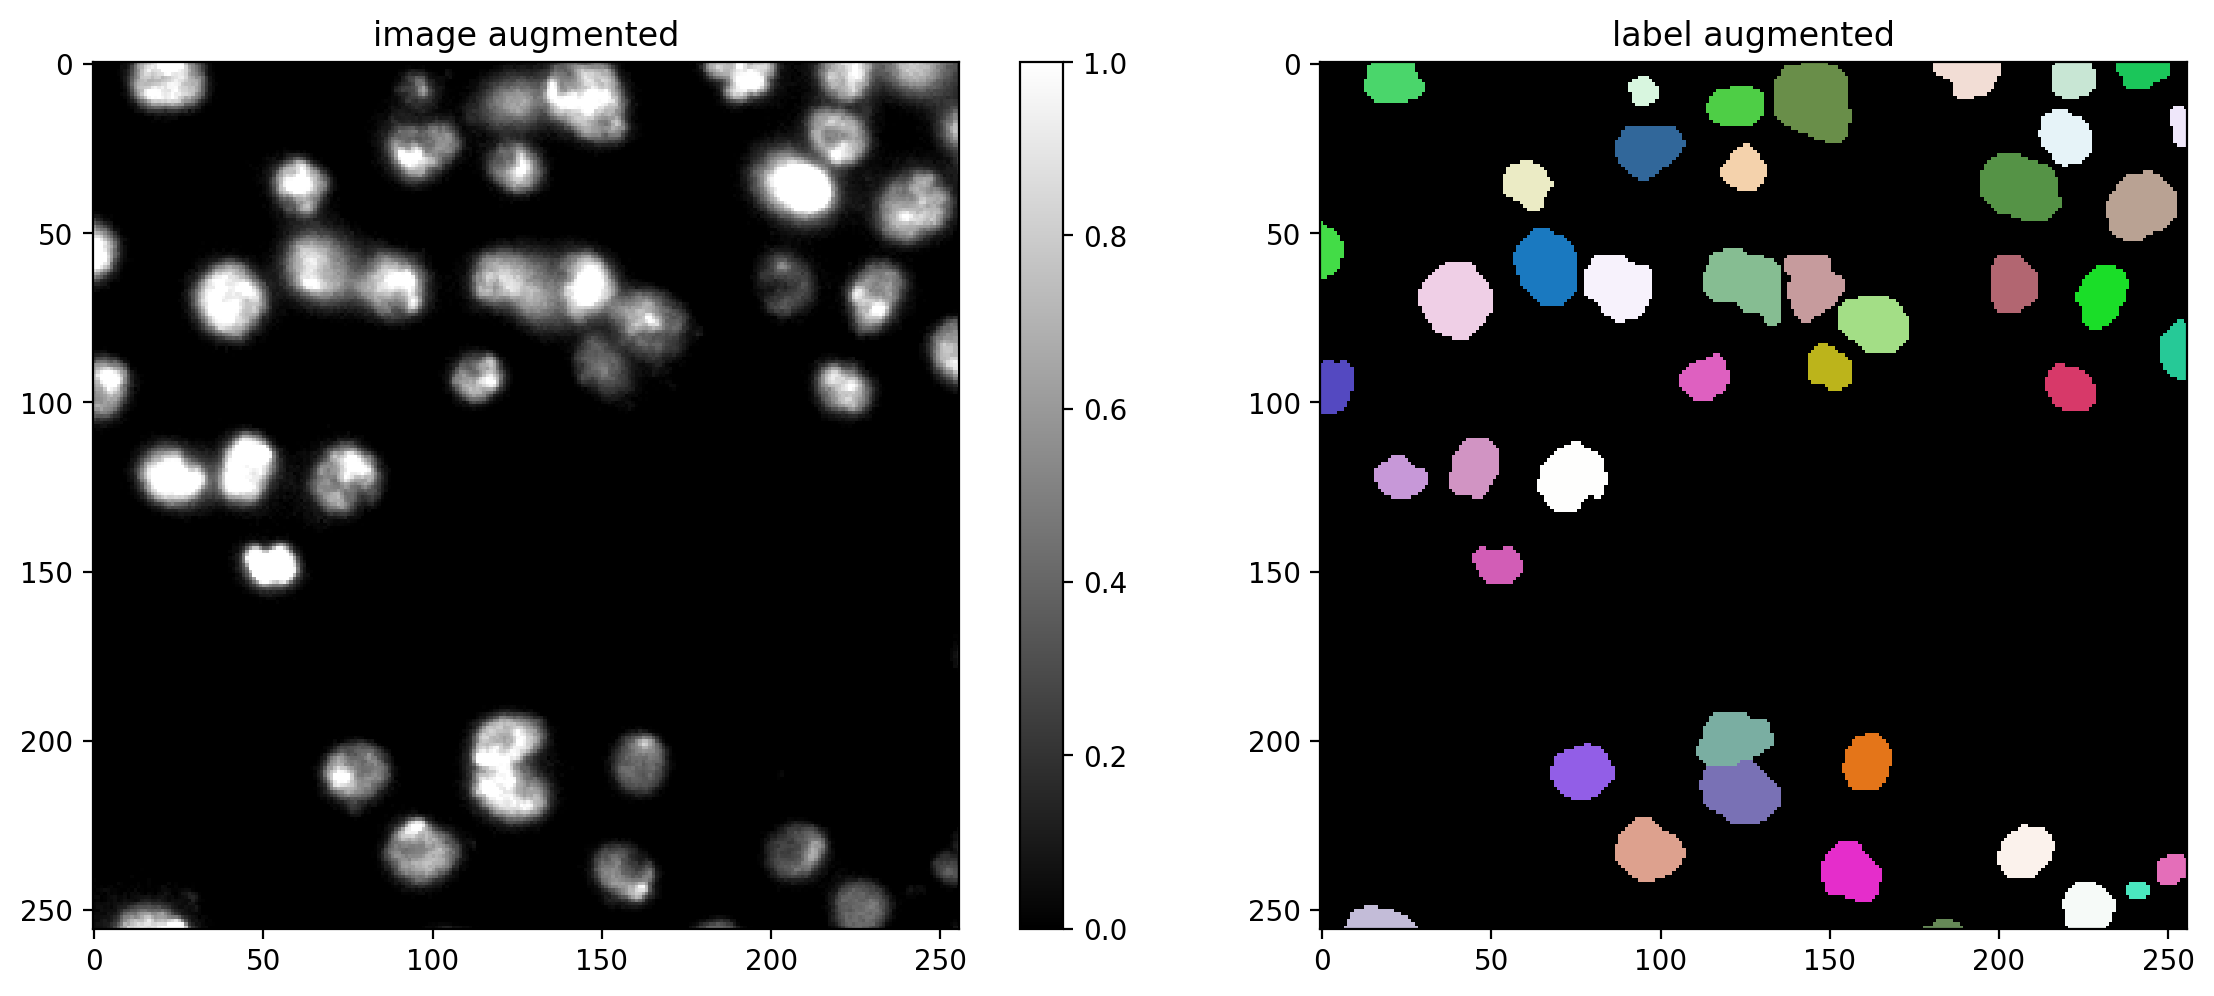

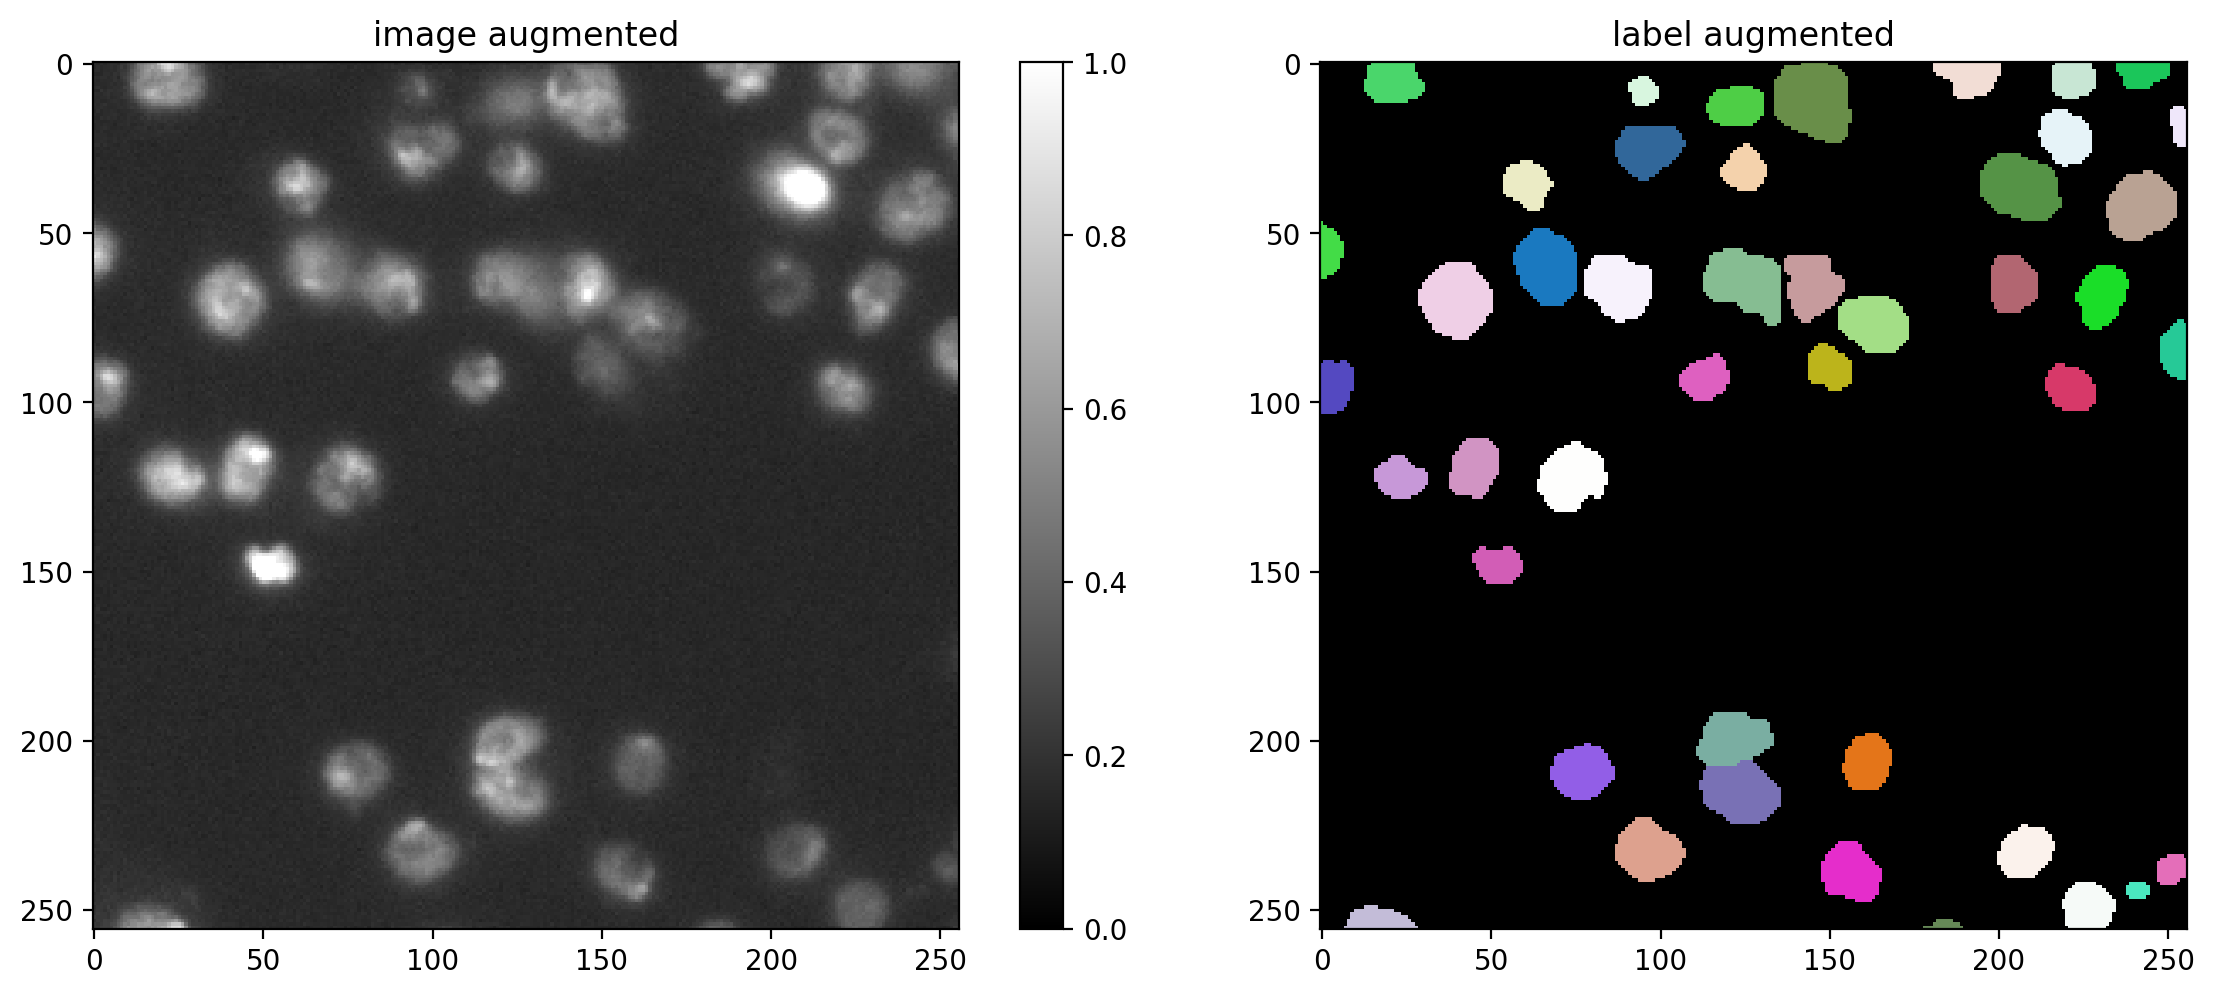

In [48]:
# plot some augmented examples
img, lbl = X[4180],Y[4180]
plot_img_label(img, lbl)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented", lbl_title="label augmented")

# Training

We recommend to monitor the progress during training with [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard). You can start it in the shell from the current working directory like this:

    $ tensorboard --logdir=.

Then connect to [http://localhost:6006/](http://localhost:6006/) with your browser.


In [ ]:
model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter)

Epoch 1/500
350/350 [==============================] - 122s 349ms/step - loss: 1.5359 - prob_loss: 0.3481 - dist_loss: 5.9391 - prob_kld: 0.2073 - dist_relevant_mae: 5.9385 - dist_relevant_mse: 85.3041 - dist_dist_iou_metric: 0.2507 - val_loss: 1.1119 - val_prob_loss: 0.2424 - val_dist_loss: 4.3474 - val_prob_kld: 0.1033 - val_dist_relevant_mae: 4.3468 - val_dist_relevant_mse: 49.6037 - val_dist_dist_iou_metric: 0.3311
Epoch 2/500
350/350 [==============================] - 127s 363ms/step - loss: 1.0597 - prob_loss: 0.2169 - dist_loss: 4.2139 - prob_kld: 0.0793 - dist_relevant_mae: 4.2133 - dist_relevant_mse: 47.1635 - dist_dist_iou_metric: 0.4001 - val_loss: 0.8574 - val_prob_loss: 0.1939 - val_dist_loss: 3.3178 - val_prob_kld: 0.0548 - val_dist_relevant_mae: 3.3172 - val_dist_relevant_mse: 28.5777 - val_dist_dist_iou_metric: 0.5014
Epoch 3/500
350/350 [==============================] - 124s 355ms/step - loss: 0.8820 - prob_loss: 0.2036 - dist_loss: 3.3922 - prob_kld: 0.0593 - dist_re

# Model evaluation

## Threshold optimisation on test images 

While the default values for the probability and non-maximum suppression thresholds already yield good results in many cases, we still recommend to adapt the thresholds to your data. The optimized threshold values are saved to disk and will be automatically loaded with the model.

This should be done on your annotated test images as they represent the images you will use StarDist onto:

In [6]:
# Loading of test images and their corresponding maks
Xt = sorted(glob('../data/stardist_haug2_training/test/images/*.tif'))
Yt = sorted(glob('../data/stardist_haug2_training/test/masks/*.tif'))
assert all(Path(xt).name==Path(yt).name for xt,yt in zip(Xt,Yt))
print(f"found {len(Xt)} training images and {len(Yt)} training masks")

found 9 training images and 9 training masks


In [7]:
# Listing images ans their corresponding masks
Xt = list(map(imread,Xt))
Yt = list(map(imread,Yt))
n_channel = 1 if Xt[0].ndim == 2 else Xt[0].shape[-1]

In [8]:
axis_norm = (0,1)   # normalize channels independently
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

Xt = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(Xt)]
Yt = [fill_label_holes(y) for y in tqdm(Yt)]

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:00<00:00, 17.39it/s]


In [9]:
# Loading of the pretrained and fine tuned models for performances comparisons
model = StarDist2D.from_pretrained('2D_versatile_fluo')
model_haug2 = StarDist2D(None, name='stardist_haug2', basedir='../models')

Found model '2D_versatile_fluo' for 'StarDist2D'.


2025-10-26 16:09:37.125255: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-26 16:09:37.125323: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.510458, nms_thresh=0.3.


In [10]:
print(model.config)

Config2D(n_dim=2, axes='YXC', n_channel_in=1, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=[3, 3], unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=[2, 2], unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=[None, None, 1], net_mask_shape=[None, None, 1], train_shape_completion=False, train_completion_crop=32, train_patch_size=[256, 256], train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=[1, 0.2], train_class_weights=(1, 1), train_epochs=800, train_steps_per_epoch=400, train_learning_rate=0.0003, train_batch_size=8, train_n_val_patches=None, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 80, 'min_delta': 0}, 

In [11]:
print(model_haug2.config)

Config2D(n_dim=2, axes='YXC', n_channel_in=1, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(1, 1), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=[3, 3], unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=[2, 2], unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=[None, None, 1], net_mask_shape=[None, None, 1], train_shape_completion=False, train_completion_crop=32, train_patch_size=[96, 96], train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=[1, 0.2], train_class_weights=[1, 1], train_epochs=500, train_steps_per_epoch=350, train_learning_rate=0.0003, train_batch_size=8, train_n_val_patches=None, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, us

In [12]:
model.optimize_thresholds(Xt, Yt)

2025-10-26 16:09:43.182444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-26 16:09:44.235759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
NMS threshold = 0.5:  80%|████████  | 16/20 [00:07<00:01,  2.13it/s, 0.460 -> 0.448]


Using optimized values: prob_thresh=0.458366, nms_thresh=0.5.


{'prob': 0.458366334438324, 'nms': 0.5}

In [13]:
model_haug2.optimize_thresholds(Xt, Yt)

2025-10-26 16:10:09.397038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-26 16:10:10.386572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
NMS threshold = 0.5:  75%|███████▌  | 15/20 [00:25<00:08,  1.72s/it, 0.606 -> 0.691]


Using optimized values: prob_thresh=0.510458, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'prob': 0.5104581312705648, 'nms': 0.3}

In [14]:
# Model predictions
Y_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(Xt)]

Y_pred_haug2 = [model_haug2.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(Xt)]

100%|██████████| 9/9 [00:04<00:00,  1.91it/s]


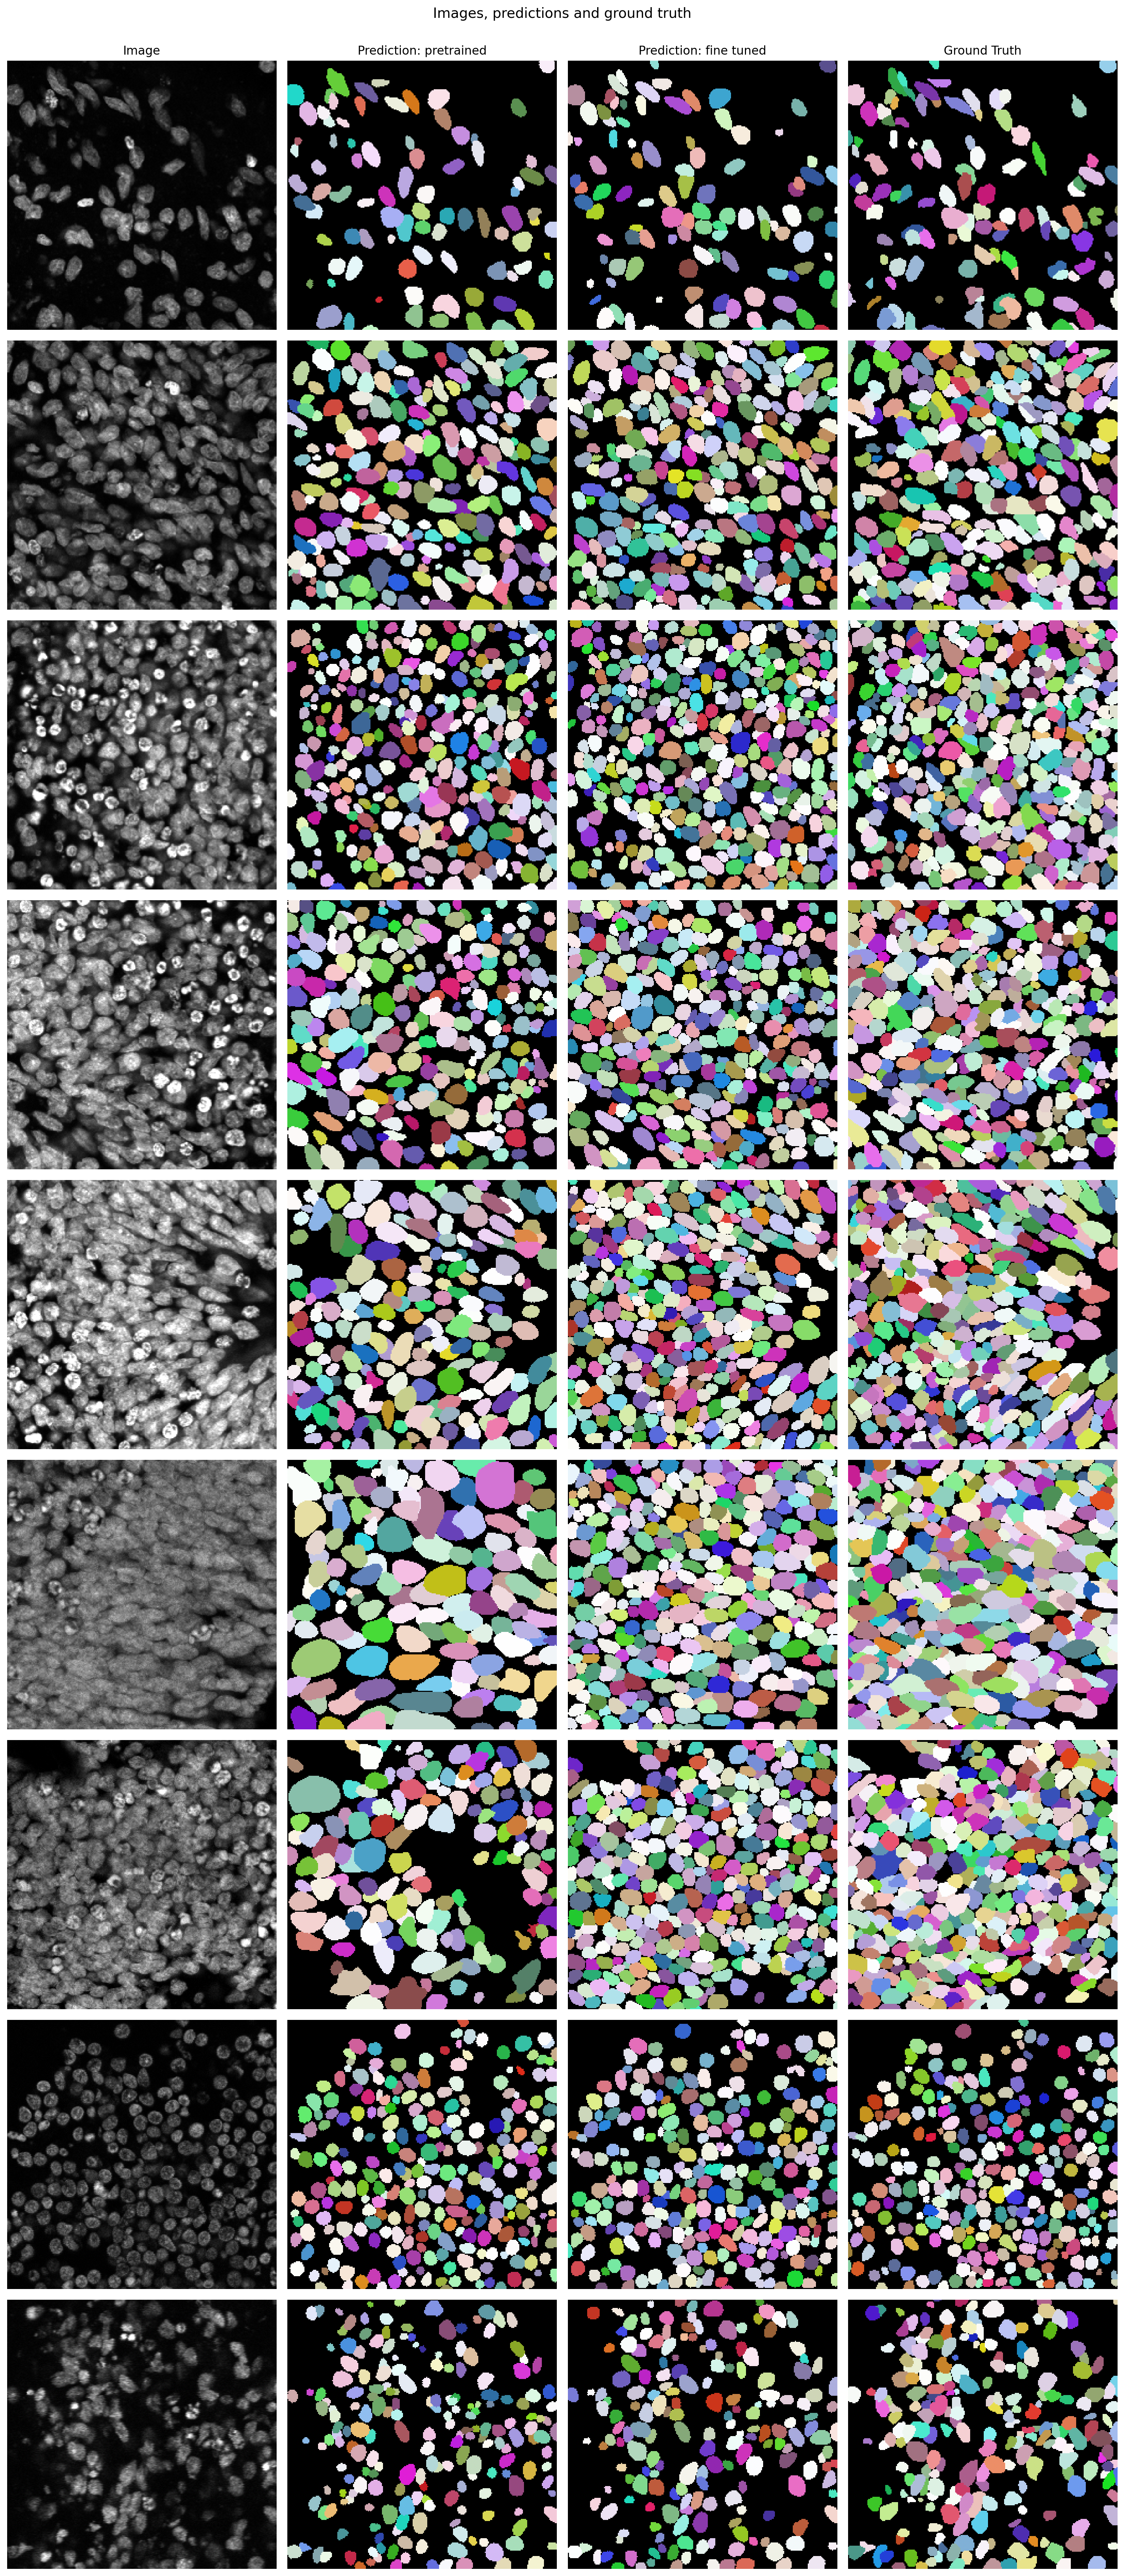

In [40]:
def plot_img_label_pred(img, pred1, pred2, lbl, ax):
    ax[0].imshow(img, cmap='gray')
    ax[0].axis('off')

    ax[1].imshow(pred1, cmap=lbl_cmap)
    ax[1].axis('off')

    ax[2].imshow(pred2, cmap=lbl_cmap)
    ax[2].axis('off')

    ax[3].imshow(lbl, cmap=lbl_cmap)
    ax[3].axis('off')

# Create larger figure
fig1, axes = plt.subplots(len(Xt), 4, figsize=(16, 4 * len(Xt)))  

# Add one main title
fig1.suptitle('Images, predictions and ground truth', fontsize=14, y =1.001)

# Add column titles only once (top row)
col_titles = ["Image", "Prediction: pretrained", "Prediction: fine tuned", "Ground Truth"]
for ax, col in zip(axes[0], col_titles):
    ax.set_title(col, fontsize=12)

# Plot images
for i, (img, pred1, pred2, lbl) in enumerate(zip(Xt, Y_pred, Y_pred_haug2, Yt)):
    plot_img_label_pred(img, pred1, pred2, lbl, axes[i])

plt.tight_layout()
plt.subplots_adjust(top=1, bottom = 0.05, hspace=0.05, wspace=0.05)
plt.tight_layout()
plt.show()

# Save
figure_name = "stardist_haug2_predictions.pdf"
fig1.savefig(f'../data/{figure_name}', dpi=300, bbox_inches='tight')


In [73]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Yt, Y_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 9/9 [00:03<00:00,  2.87it/s]


In [74]:
taus_haug2 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats_haug2 = [matching_dataset(Yt, Y_pred_haug2, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 9/9 [00:03<00:00,  2.78it/s]


In [75]:
stats[taus.index(0.5)]

DatasetMatching(criterion='iou', thresh=0.5, fp=363, tp=1385, fn=1151, precision=0.7923340961098398, recall=0.5461356466876972, accuracy=0.4777509486029665, f1=0.6465919701213819, n_true=2536, n_pred=1748, mean_true_score=0.40794559382489803, mean_matched_score=0.7469675277544703, panoptic_quality=0.482983205387461, by_image=False)

In [76]:
stats_haug2[taus.index(0.5)]

DatasetMatching(criterion='iou', thresh=0.5, fp=343, tp=2133, fn=403, precision=0.8614701130856219, recall=0.8410883280757098, accuracy=0.7408822507815214, f1=0.8511572226656026, n_true=2536, n_pred=2476, mean_true_score=0.6658732958772581, mean_matched_score=0.7916805805648038, panoptic_quality=0.6738446441918302, by_image=False)

You can see great improvements in the f1 score after fine tuning. You can now use this model to work on your own images. Go and run the script: in the folder scripts.